In [2]:
import json, os
import numpy as np
import matplotlib.pyplot as plt
def read_json(pth):
    assert os.path.exists(pth)
    with open(pth) as fp:
        return json.load(fp)

def to_json(obj, pth):
    with open(pth, "w") as fp:
        json.dump(obj, fp)


In [3]:
preds = read_json("data/output/1RchFn-zZDw-results.json")

print(preds[0].keys())
for pred in preds:
    print(
        pred['image_id'],
        pred['category_id'],
        np.array(pred['keypoints']).shape,
        pred['score'],
        np.array(pred['box']),
        pred['idx'],
    )
    break





dict_keys(['image_id', 'category_id', 'keypoints', 'score', 'box', 'idx'])
0.jpg 1 (51,) 3.1060922145843506 [533.31903076 268.63006592 243.50982666 263.4899292 ] [0.0]


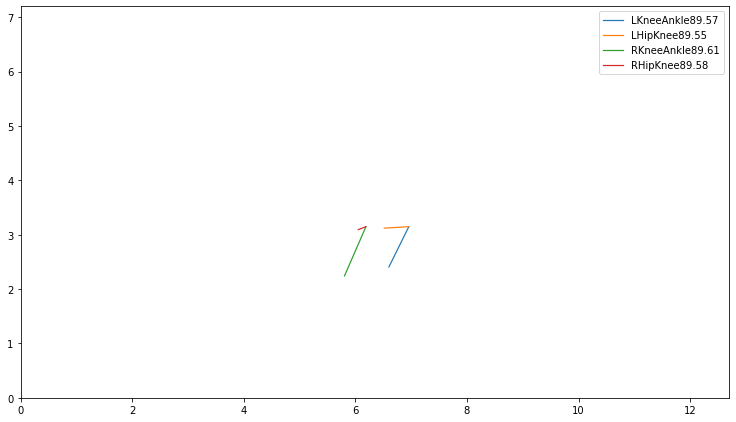

In [74]:
gt_labels = {
        "Nose"          : np.array([0], dtype=int),
        "LEye"          : np.array([1], dtype=int),
        "REye"          : np.array([2], dtype=int),
        "LEar"          : np.array([3], dtype=int),
        "REar"          : np.array([4], dtype=int),
        "LShoulder"     : np.array([5], dtype=int),
        "RShoulder"     : np.array([6], dtype=int),
        "LElbow"        : np.array([7], dtype=int),
        "RElbow"        : np.array([8], dtype=int),
        "LWrist"        : np.array([9], dtype=int),
        "RWrist"        : np.array([10], dtype=int),
        "LHip"          : np.array([11], dtype=int),
        "RHip"          : np.array([12], dtype=int),
        "LKnee"         : np.array([13], dtype=int),
        "RKnee"         : np.array([14], dtype=int),
        "LAnkle"        : np.array([15], dtype=int),
        "RAnkle"        : np.array([16], dtype=int),

}

joints = {
        "LArm_joint" : ["LWrist", "LElbow", "LShoulder"],
        "RArm_joint" : ["RWrist", "RElbow", "RShoulder"],
        "LLeg_joint" : ["LAnkle", "LKnee", "LHip"],
        "RLeg_joint" : ["RAnkle", "RKnee", "RHip"],
}

joint_length = {
        ("Knee", "Ankle") :  (1938.3904646082083 + 1924.7187497200205) / 2,
        ("Hip", "Knee") : 1875.865770668652
}

class Skeleton:
        def get_angle(self, ptA, ptB, ptC):
                dist = lambda x, y: torch.dist(x, y, p=2)
                lnAB = dist(ptA, ptB)
                lnBC = dist(ptB, ptC)
                lnAC = dist(ptA, ptC)
                theta = np.arccos(((lnAB**2) + (lnBC**2) - (lnAC**2)) / (2 * lnAB * lnBC))
                return np.degrees(theta)

        def add_centroids(self, d):
                for key in ['Hip', 'Ankle', 'Knee', 'Shoulder', 'Wrist']:
                        d[f"C{key}"] = (d[f"L{key}"] + d[f"R{key}"]) / 2
                return d
                
        def add_angles(self, d):
                # Use law of cosines.
                for j, (ka, kb, kc) in joints.items():
                        d[j] = self.get_angle(d[ka], d[kb], d[kc])
                return d
        
        def calc_perspective(self, x1, y1, x2, y2, xx, yy):
                a = np.sqrt((x1 + x2)**2 + (y1 + y2)**2)
                b = joint_length[(xx, yy)]
                
                return np.degrees(np.arccos(a / b))
                
                # return 0
        def plot(self):
                fig = plt.figure(figsize=(12.70, 7.20))
                ax = fig.add_subplot(111)
                ax.set_ylim([0, 7.20])
                ax.set_xlim([0, 12.70])

                # for k, v in self.feat_dict.items():
                for dir in ['L', 'R']:
                        for (xx, yy) in [('Knee', 'Ankle'), ('Hip', 'Knee')]: # ('Elbow', 'Wrist'), ('Shoulder', 'Elbow')
                                x1, y1, _ = (self.feat_dict[dir+xx]) / 100
                                x2, y2, _ = (self.feat_dict[dir+yy]) / 100
                                y1 = abs(7.20 - y1)
                                y2 = abs(7.20 - y2)
                                perspective = self.calc_perspective(x1, y1, x2, y2, xx, yy)
                                ax.plot([x1, x2], [y1, y2], linewidth=1.2, label=dir+xx+yy+str(perspective.round(2)))
                        # if all(kk not in k for kk in ['Hip', 'Knee', 'Ankle']): continue
                        # ax.scatter(v[0] / 100, v[1] / 100, label=k)
                ax.legend()

        def __init__(self, arr):
                raw_input = np.array(arr).reshape(-1, 3)
                self.feat_dict = {k : raw_input[v.item()] for (k, v) in gt_labels.items()}
                self.feat_dict = self.add_centroids(self.feat_dict)
                # self.feat_dict = self.add_angles(self.feat_dict)
                # print(self.feat_dict)
                

s = Skeleton(preds[42]['keypoints'])
s.plot()

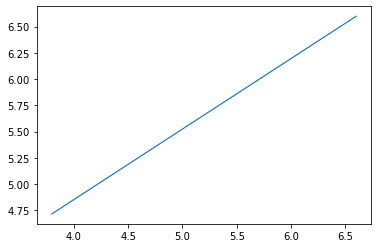

In [33]:
# ((x1, y1), (x2, y2)) =  ((6.598300170898438, 3.797655029296875), (6.598300170898438, 4.717158203125))

# plt.plot([x1, y1], [x2, y2], linewidth=1.2)
